# 1. Linear model, predicting price BTC from price of DASH

## Imports

Import pacakges

In [60]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
# the mock-0.3.1 dir contains testcase.py, testutils.py & mock.py
sys.path.append('../')

import pystan
import stan_utility

## Data

Initialize data

In [61]:
data = pd.read_csv('/home/jonatan/projects/school/BDA_Project/data/selected/combined.csv', delimiter=",")
data = data[['BTC price(USD)', 'DASH price(USD)']]
#data = (data - data.mean()) / (data.max() - data.min())
print(data)

     BTC price(USD)  DASH price(USD)
0            655.41             9.36
1            661.26             9.24
2            654.23             9.15
3            651.63             8.90
4            654.49             9.15
5            655.11             9.32
6            657.01             9.45
7            655.10             9.18
8            624.60             9.45
9            606.40            10.02
10           548.66             9.29
11           566.33             9.32
12           578.28             9.53
13           575.03             9.71
14           587.77            10.59
15           592.74            10.34
16           591.04            10.35
17           587.65            10.32
18           592.12            10.44
19           588.80            11.09
20           587.36            12.56
21           585.59            12.82
22           570.49            14.52
23           567.24            13.23
24           577.76            12.91
25           573.71            12.45
2

In [62]:
n = data.shape[0]
m = 10
x = data[['BTC price(USD)']].values.flatten()[0:n]
y = data[['DASH price(USD)']].values.flatten()[0:n]
p = np.linspace(data[['BTC price(USD)']].min(), data[['BTC price(USD)']].max(), m)
print(p)

[  548.66        2651.67555556  4754.69111111  6857.70666667
  8960.72222222 11063.73777778 13166.75333333 15269.76888889
 17372.78444444 19475.8       ]


## Read and display edited stan code


In [63]:
with open('lin_ex2.stan') as file:
    print(file.read())

data {
	int<lower=0> N;	// number of data points
	int<lower=0> M;	// number of prediction points
	vector[N] x;	// Coin 1
	vector[N] y;	// Coin 2
	vector[M] xpreds;	// Coin 1 hypothetical future prices
}
parameters {
	real alpha;
	real beta;
	real sigma;
}
transformed parameters {
  vector[N] mu;
  mu = alpha + beta*x;
}
model {
	beta ~ normal(0, 1);
	y ~ normal(mu, sigma);
}
generated quantities {
	vector[M] ypreds; // Predictions based on hypothetical future prices of coin 1
	vector[N] log_lik;
	for(i in 1:M) {
		ypreds[i] = normal_rng(alpha + beta*xpreds[i], sigma);
	}
	for (i in 1:N){
        log_lik[i] = normal_lpdf(y[i] | mu[i], sigma);
	}
}



## Generate model

In [64]:
model = stan_utility.compile_model('lin_ex2.stan')

Using cached StanModel


## Set model data

In [65]:
data1 = dict(
    N=n,
    M=m,
    x=x,
    y=y,
    xpreds=p
)
fit1 = model.sampling(data=data1, seed=74749)
samples1 = fit1.extract(permuted=True)
print(samples1)

OrderedDict([('alpha', array([-48.04731942, -40.17242543, -36.04711514, ..., -40.09214386,
       -57.64233826, -57.56683442])), ('beta', array([0.05931098, 0.06007346, 0.05951384, ..., 0.05825371, 0.06181628,
       0.06193951])), ('sigma', array([109.50304523, 113.53510349, 110.46616854, ..., 112.53977287,
       112.49830698, 112.75794749])), ('mu', array([[ -9.17431089,  -8.82734166,  -9.24429784, ..., 209.81842945,
        182.1255404 , 190.09041172],
       [ -0.79967865,  -0.44824891,  -0.87056533, ..., 221.00835828,
        192.95945882, 201.02672383],
       [  2.95885314,   3.30700913,   2.8886268 , ..., 222.70062784,
        194.91301909, 202.90513316],
       ...,
       [ -1.91207852,  -1.57129431,  -1.9808179 , ..., 213.17693697,
        185.97769633, 193.80058731],
       [-17.12732955, -16.7657043 , -17.20027276, ..., 211.11568838,
        182.25304862, 190.554357  ],
       [-16.97106094, -16.60871482, -17.04414956, ..., 211.72694869,
        182.80677263, 191.12462927

(4000,)


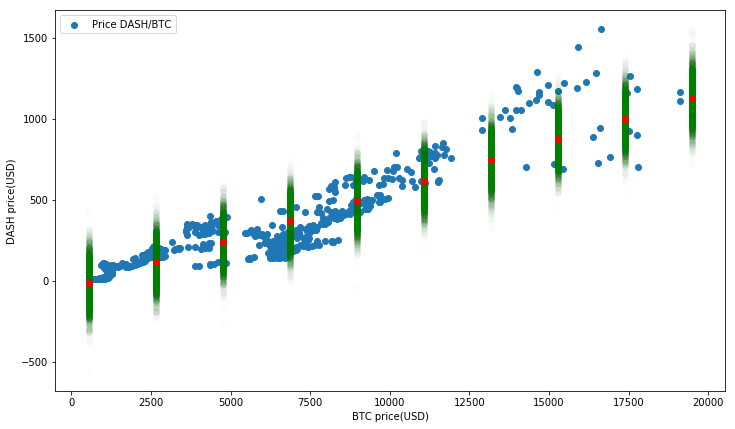

In [66]:
preds = samples1['ypreds'].T
print(preds[0].shape)
f, ax = plt.subplots(1, 1, figsize=(12,7), sharex=True)
ax.scatter(data['BTC price(USD)'], data['DASH price(USD)'], label='Price DASH/BTC')
ax.set_ylabel('DASH price(USD)')
ax.set_xlabel('BTC price(USD)')
for i in range(m):
    ax.scatter([p[i]]*len(preds[i]),preds[i], alpha=0.01, c='g')
    ax.scatter(p[i],np.mean(preds[i]), c='r')
plt.legend(loc='best')
plt.show()

## Plot ypred histogram

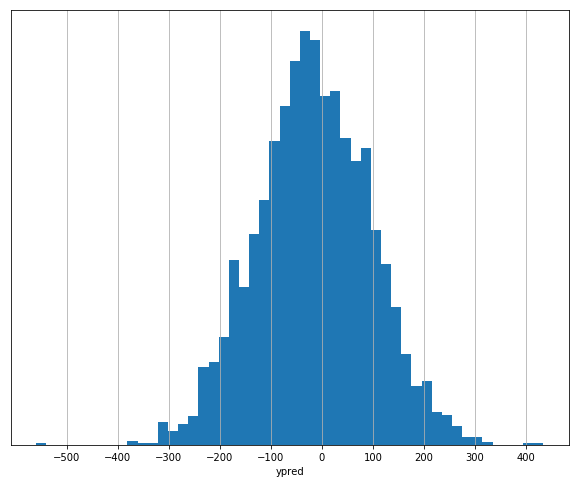

In [75]:
# plot beat histogram
fig, ax = plt.subplots(1, 1, figsize=(10,8))

# plot post pred histogram
ax.set_xlabel('ypred')
ax.set_ylabel('')
ax.set_yticks([])
ax.set_xticks(np.linspace(-500, 400, 10))
ax.grid(axis='x')
s = pd.Series(preds[0])
ax.hist(s, bins=50)
plt.show()


In [68]:
from psis import psisloo

In [69]:
loglik = samples1['log_lik']
loo1, loos, ks = psisloo(loglik)
print("Loo: {}".format(loo1))

Loo: -5245.654198239507


In [72]:
ks1 = [[
(ks <= 0.5).sum(),
sum([1 for k in ks if k > 0.5 and k <= 0.7]),
(ks > 0.7).sum()]]
pd.DataFrame(ks1,
columns=["k<=0.5","0.5<k<=0.7","0.7<k"])
print(ks)

[-0.19797156 -0.1977893  -0.19860216 -0.19898326 -0.19866171 -0.19778403
 -0.19788501 -0.19864818 -0.20032577 -0.20259019 -0.18556045 -0.19413276
 -0.19486131 -0.19425072 -0.19421957 -0.19982744 -0.1950712  -0.19471865
 -0.19509371 -0.19351343 -0.18432877 -0.17903026 -0.1756917  -0.17593202
 -0.18392767 -0.18039255 -0.17600101 -0.17625567 -0.18281321 -0.18619677
 -0.17755738 -0.18668567 -0.18694126 -0.1797049  -0.17883114 -0.18578244
 -0.1784742  -0.18630915 -0.18435062 -0.18520565 -0.18484912 -0.18707018
 -0.19462898 -0.20112405 -0.1988339  -0.20352199 -0.20355887 -0.20060841
 -0.20313486 -0.20165808 -0.20090237 -0.19304997 -0.1867309  -0.19034865
 -0.19350766 -0.19475856 -0.19437423 -0.19495197 -0.19608255 -0.19483799
 -0.19382867 -0.19338363 -0.19443855 -0.19456061 -0.19442235 -0.19715609
 -0.19486743 -0.19465688 -0.19450505 -0.19444806 -0.20038994 -0.19557533
 -0.19660357 -0.19451651 -0.19486279 -0.1949268  -0.20089678 -0.20035584
 -0.2002036  -0.20180042 -0.20282297 -0.20243839 -0

In [71]:
S = np.size(loglik, 0)
lppd = sum(np.log([1/S*sum(np.exp(col)) for col in loglik.T]))
p_loocv = lppd - loo1
print(p_loocv)

5.470369184769879
